In [ ]:
# Lasso
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def subGrad(iter,lr,regularization):
    x = np.random.normal(0,0.1,A.shape[1])
    iter = int(iter)
    loss1 = []
    loss2 = []
    for i in range(iter):
        # compute a subgradient
        g = np.zeros(x.shape[0])
        g[x>0] = 1
        g[x<0] = -1
        g *= regularization
        g += ATA.dot(x) - ATb
        x -=  lr * g
        # calculate loss
        loss_train = np.linalg.norm(A.dot(x)-b,2)
        loss_test = np.linalg.norm(A_test.dot(x)-b_test,2)
        loss1.append(loss_train)
        loss2.append(loss_test)
    return range(iter),loss1,loss2

def Pl(x,lr,regularization):
    # Pl() operator in paper Breck's FISTA paper
    # compute a subgradient of g(x)
    g = ATA.dot(x) - ATb
    x -= lr *g
    # soft threshold
    eta = lr*regularization
    x[np.abs(x)<=eta] = 0
    x[x>eta] = x[x>eta] - eta
    x[x<-eta] = x[x<-eta] + eta
    return x

def ISTA(iter,lr,regularization):
    x = np.random.normal(0,0.1,A.shape[1])
    iter = int(iter)
    loss1 = []
    loss2 = []
    lipschitz = np.linalg.svd(ATA)[1][0]
    for i in range(iter):
        x = Pl(x,lr,regularization)
        # calculate loss
        loss_train = np.linalg.norm(A.dot(x)-b,2)
        loss_test = np.linalg.norm(A_test.dot(x)-b_test,2)
        loss1.append(loss_train)
        loss2.append(loss_test)
    return range(iter),loss1,loss2

def FISTA(iter,lr,regularization):
    old_x = np.random.normal(0,0.1,A.shape[1])
    old_y = old_x.copy()
    old_t = 1
    iter = int(iter)
    loss1 = []
    loss2 = []
    lipschitz = np.linalg.svd(ATA)[1][0]
    for i in range(iter):
        new_x = Pl(old_y,lr,regularization)
        new_t = (1+np.sqrt(1+4*old_t**2))/2
        new_y = new_x + (new_x - old_x)*(old_t-1)/(new_t)
        # calculate loss
        x = new_y
        loss_train = np.linalg.norm(A.dot(x)-b,2)
        loss_test = np.linalg.norm(A_test.dot(x)-b_test,2)
        loss1.append(loss_train)
        loss2.append(loss_test)
        # update x,y,t
        old_x,old_y,old_t = new_x,new_y,new_t
    return range(iter),loss1,loss2

def FrankWolfe(iter,lr,regularization):
    k = 1000
    x = np.random.normal(0,0.1,A.shape[1])
    iter = int(iter)
    loss1 = []
    loss2 = []
    for i in range(iter):
        # compute a subgradient
        g = np.zeros(x.shape[0])
        g[x>0] = 1
        g[x<0] = -1
        g *= regularization
        g += ATA.dot(x) - ATb
        # minimize < g , y > over radius-k ball
        y = - k * g / np.linalg.norm(g)
        x = x * (1-lr) + y * lr
        # calculate loss
        loss_train = np.linalg.norm(A.dot(x)-b,2)
        loss_test = np.linalg.norm(A_test.dot(x)-b_test,2)
        loss1.append(loss_train)
        loss2.append(loss_test)
    return range(iter),loss1,loss2

# load data
A = np.load('./data/A_train.npy')
b = np.load('./data/b_train.npy')

A_test = np.load('./data/A_test.npy')
b_test = np.load('./data/b_test.npy')

ATA = A.T.dot(A)
ATb = A.T.dot(b)
lipschitz = np.linalg.svd(ATA)[1][0] # smoothness of g()
# set up
iter = 1e+4
fig, axs = plt.subplots(1,2,sharex=True,figsize=(16,8))
axs[1].set_title('Test loss')
axs[0].set_title('Training loss')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')

# subgradient method
i,loss_train,loss_test = subGrad(iter,1e-6,20)
l1, = axs[0].plot(i,loss_train,'blue',label='SGD')
l5,=axs[1].plot(i,loss_test,'blue')


# ISTA
i,loss_train,loss_test = ISTA(iter,1e-6,20)
l2, = axs[0].plot(i,loss_train,'red',label='ISTA')
l6,=axs[1].plot(i,loss_test,'red')

# FISTA
i,loss_train,loss_test = FISTA(iter,1e-6,20)
l3, = axs[0].plot(i,loss_train,'black',label='FISTA')
l7,=axs[1].plot(i,loss_test,'black')

# FrankWolfe
i,loss_train,loss_test = FrankWolfe(iter,1e-6,20)
l4, = axs[0].plot(i,loss_train,'green',label='FW')
l8,=axs[1].plot(i,loss_test,'green')

plt.legend([l1,l2,l3,l4]+[l5,l6,l7,l8],['SGD','ISTA','FISTA','FW']+['SGD','ISTA','FISTA','FW'],loc='best')
# show plots
plt.show()

number of training samples: 12564
start training model...
iteration 1
iteration 101
iteration 201
iteration 301
iteration 401
iteration 501
iteration 601
iteration 701
iteration 801
iteration 901


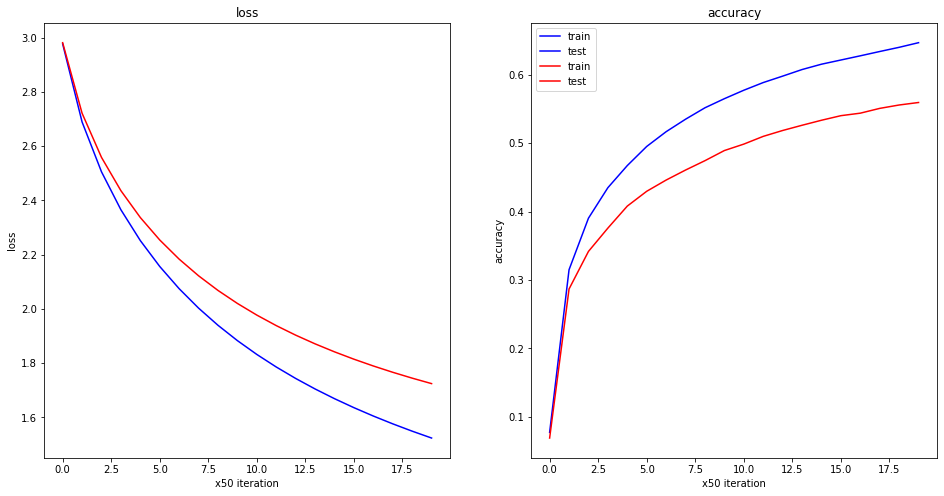

In [3]:
# LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import argparse
import os
from scipy.special import softmax

class LogisticRegression(object):

    def __init__(self,n_feature,n_class,regularization = 0):
        self.n_feature = n_feature
        self.n_class = n_class
        self.regularization = regularization

    def fit(self,X,y,optimizer='GD',iter=1e+4,lr=1e-3,batch=32,log_path='./'):
        print("start training model...")
        assert (X.shape[1]==self.n_feature), 'mismatch: number of features'
        assert (y.max()<=self.n_class-1), 'mismatch: max index of classes'
        assert (y.min()>=0), 'mismatch: min index of classes'

        self.N = X.shape[0]
        self.X = X
        self.y = y
        self.y_onehot = np.eye(self.n_class)[self.y]
        self.B = np.random.normal(0,0.1,(self.n_feature,self.n_class))

        test_loss_list = []
        train_loss_list = []
        test_acc_list = []
        train_acc_list = []

        # parameters for nesterov
        AGD_lambda_old = 0
        AGD_lambda_new = None
        AGD_gamma = None
        AGD_y_old = self.B
        AGD_y_new = None

        # log data
        min_loss_test = np.inf
        min_loss_iter = 0
        min_loss_acc = 0
        file_old = None

        for i in range(iter):
            if optimizer == 'GD':
                self.back_prop(batch=batch)
                self.B += lr * (-self.G)
            elif optimizer == 'AGD':
                self.back_prop(batch=batch)
                AGD_y_new = self.B - lr * self.G
                AGD_lambda_new = (1+np.sqrt(1+4*AGD_lambda_old**2))/2
                AGD_gamma = (1-AGD_lambda_old)/AGD_lambda_new
                self.B = (1-AGD_gamma) * AGD_y_new + AGD_gamma * AGD_y_old

                AGD_y_old = AGD_y_new
                AGD_lambda_old = AGD_lambda_new

            # test and record
            if i % 50 == 1:
                loss,acc = self.getLoss(self.X,self.y,self.B,0)
                test_loss,test_acc = self.getLoss(self.X_test,self.y_test,self.B,0)

                test_loss_list.append(test_loss)
                train_loss_list.append(loss)
                test_acc_list.append(test_acc)
                train_acc_list.append(acc)

                if test_loss < min_loss_test:
                    min_loss_test = test_loss
                    min_loss_iter = i
                    min_loss_acc = test_acc
                if i%100 == 1:
                    print('iteration %s'%i)

        return train_loss_list,train_acc_list,test_loss_list,test_acc_list



    def getLoss(self,X,y,B,regularization = 0):
        N = X.shape[0]
        scores = - X.dot(B) # N x n_class
        prob_matrix = np.zeros((N,self.n_class))
        for i in range(N):
            for j in range(self.n_class):
                prob_i_j = np.exp(scores[i,j])/np.exp(scores[i,:]).sum()
                prob_matrix[i,j] = prob_i_j
        loss = 0
        for i in range(N):
            loss += -scores[i,y[i]]
            loss += np.log(np.exp(scores[i,:]).sum())
        loss /= N
        loss += regularization * ((B ** 2).sum())
        predict = prob_matrix.argmax(axis=1)
        accuracy = (predict == y[:N]).sum()/N
        return loss,accuracy

    def back_prop(self,batch=32):        # compute gradient, stored in self.G
        if batch is None:
            # using all samples to calculate gradient
            Xs = self.X
            onehot_ys = self.y_onehot
            batch = self.X.shape[0]
        else:
            batch_samples = np.random.choice(self.N,batch,replace=False)
            Xs = self.X[batch_samples]
            onehot_ys = self.y_onehot[batch_samples]
 
        class_scores = - Xs.dot(self.B) # N x n_class
        probs = softmax(class_scores,axis=1)
        self.G = Xs.T.dot(onehot_ys - probs)
        # approximate expectation
        self.G /= batch
        # add graient of regularization term
        self.G += 2 * self.regularization * self.G

    def predict(self,X_test):
        print("not implemented")



BATCH_SIZE = None # None means calculating gradient using all samples, change it to other values like 128, 256 and it becomes SGD
LR = 10
MU = 0
ITER = 1000
OPTIMIZER = 'GD' # GD or AGD

# load data
X = np.array(pd.read_csv('data/logistic_news/X_train.csv',header=None))
y = np.array(pd.read_csv('data/logistic_news/y_train.csv',header=None))[0]
X_test = np.array(pd.read_csv('data/logistic_news/X_test.csv',header=None))
y_test = np.array(pd.read_csv('data/logistic_news/y_test.csv',header=None))[0]
print('number of training samples:',X.shape[0])

# run SGD
model = LogisticRegression(n_feature=X.shape[1],n_class=20,regularization = MU)
model.X_test = X_test
model.y_test = y_test
train_loss,train_acc,test_loss,test_acc = model.fit(X,y,optimizer=OPTIMIZER,iter=ITER,lr=LR,batch=BATCH_SIZE)
# draw plots
fig,axs = plt.subplots(1,2,figsize=(16,8))
l1, = axs[0].plot(train_loss,'blue')
l3, = axs[0].plot(test_loss,'red')
axs[0].set_title('loss')
axs[0].set_xlabel('x50 iteration')
axs[0].set_ylabel('loss')

l2, = axs[1].plot(train_acc,'blue')
l4, = axs[1].plot(test_acc,'red')
axs[1].set_title('accuracy')
axs[1].set_xlabel('x50 iteration')
axs[1].set_ylabel('accuracy')

plt.legend([l1,l2,l3,l4],['train','test','train','test'],loc='best')
plt.show()

In [ ]:
# Robust Regression and Mirror Descent
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import argparse
import os
from scipy.special import softmax

class RobustRegression(object):
    def __init__(self):
        pass

    def fit(self,X,y,iter=1000,lr=0.1):
        train_loss_list = []
        assert X.shape[0] == y.shape[0], 'mismatch number of samples and labels'
        self.N, self.n_feature = X.shape
        self.B = np.random.normal(0,1,self.n_feature)
        self.X = X
        self.y = y
        for i in range(iter):
            # gradient step
            self.back_prop()
            self.B += -lr*self.G
            self.B = self.projsplx(self.B)
            if i % 10 == 1:
                loss = self.getLoss()
                print('iter: %s, loss: %s'%(i,loss))
                train_loss_list.append(loss)
        return train_loss_list

    def fit_MD(self,X,y,iter=1000,lr=0.1):
        train_loss_list = []
        assert X.shape[0] == y.shape[0], 'mismatch number of samples and labels'
        self.N, self.n_feature = X.shape
        self.B = np.random.normal(0,1,self.n_feature)
        self.X = X
        self.y = y
        for i in range(iter):
            self.back_prop()
            # Mirror Descent step
            # by solving min lr < gt,x > + D(x,xt)
            # optimal point is xt/exp(lr gt)
            self.B = self.B / np.exp(lr * self.G)
            self.B = self.projsplx(self.B)

            if i % 10 == 1:
                loss = self.getLoss()
                print('iter: %s, loss: %s'%(i,loss))
                #print(self.B)
                train_loss_list.append(loss)
        return train_loss_list

    def getLoss(self):
        return np.linalg.norm(self.X.dot(self.B)-self.y)

    def back_prop(self):
        predict = self.X.dot(self.B) - self.y
        predict[predict>0] = 1
        predict[predict<0] = -1
        self.G = self.X.T.dot(predict)

    def projsplx(self,y):
        """projsplx projects a vector to a simplex
        by the algorithm presented in
        (Chen an Ye, "Projection Onto A Simplex", 2011)"""
        assert len(y.shape) == 1
        N = y.shape[0]
        y_flipsort = np.flipud(np.sort(y))
        cumsum = np.cumsum(y_flipsort)
        t = (cumsum - 1) / np.arange(1,N+1).astype('float')
        t_iter = t[:-1]
        t_last = t[-1]
        y_iter = y_flipsort[1:]
        if np.all((t_iter - y_iter) < 0):
            t_hat = t_last
        else:
        # find i such that t>=y
            eq_idx = np.searchsorted(t_iter - y_iter, 0, side='left')
            t_hat = t_iter[eq_idx]
        x = y - t_hat
        # there may be a numerical error such that the constraints are not exactly met.
        x[x<0.] = 0.
        x[x>1.] = 1.
        assert np.abs(x.sum() - 1.) <= 1e-5
        assert np.all(x >= 0) and np.all(x <= 1.)
        return x


ITER = 2000
X = np.load('data/X.npy')
y = np.load('data/y.npy')
model = RobustRegression()
train_loss = model.fit(X,y,iter=ITER,lr=0.0001)
train_loss_MD = model.fit_MD(X,y,iter=ITER,lr=0.0001)
plt.plot(train_loss,'blue')
plt.plot(train_loss_MD,'red')
plt.title('loss')
plt.show()

# Matrix Completion
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import argparse
import os
from scipy.special import softmax

# find a subgradient of ||A||*
def subgradient_nuclear_norm(A,epsilon=1e-5):
    m,n = A.shape
    U,S,VT = np.linalg.svd(A)
    V = VT.T
    # rank of A
    rank = (S > epsilon).sum()
    #print(rank)
    U1,U2 = U[:,:rank],U[:,rank:]
    V1,V2 = V[:,:rank],V[:,rank:]
    # generate a T with singular values uniformly distributed on [0,1]
    T_rank = min(m-rank,n-rank)
    T = np.random.uniform(0,1,T_rank)
    Im = np.identity(m-rank)
    In = np.identity(n-rank)
    T = Im.dot(np.diag(T)).dot(In)
    subgrad = U1.dot(V1.T) + U2.dot(T).dot(V2.T)

    return subgrad

def project(X,M,O):
    A = np.multiply(X,1-O) # for entries outside Ω
    B = np.multiply(M,O) # for entries in Ω
    return A+B

def optimize(X,M,O,step_size,iteration):
    loss = 0
    for i in range(iteration):
        subgrad = subgradient_nuclear_norm(X)
        X += - step_size * subgrad
        X = project(X,M,O)
    loss = ((X-M)**2).sum()/10000
    return loss



k_list = np.array([1,10,20,30,40,50,60,70,80,90,100])**2
M = np.array(pd.read_csv('data/MatrixCompletion/M.csv',header=None))
O = np.array(pd.read_csv('data/MatrixCompletion/O.csv',header=None))
X = np.multiply(M,O)
loss1_list = []
loss2_list = []
for k in k_list:
    loss1 = optimize(X,M,O,1/np.sqrt(k),k)
    loss2 = optimize(X,M,O,1/k,k)
    print(k,loss1,loss2)
    loss1_list.append(loss1)
    loss2_list.append(loss2)

plt.plot(k_list,loss1_list)
plt.plot(k_list,loss2_list)
plt.show()